In [1]:
import time
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F  # useful stateless functions

import numpy as np
from PIL import Image
import torch.utils.data.dataset as datautil


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

In [2]:
# need to do this twice for it to work for some reason
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# Load preprocessed dataset mean and standard deviation 

Text(0.5,1,'Std image')

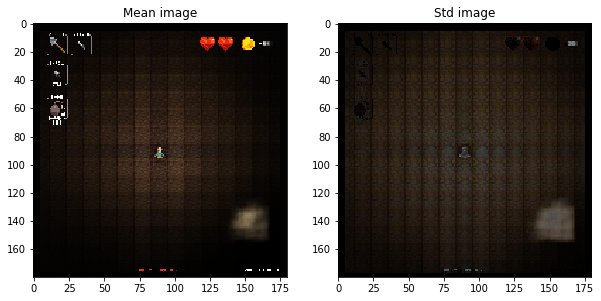

In [3]:
dset_mean = np.load("data/stats/dsetMean.npy")
dset_std = np.load("data/stats/dsetStd.npy")

plt.subplot(121)
plt.imshow(np.array(np.round(dset_mean), dtype=np.uint8))
plt.title("Mean image")
plt.subplot(122)
plt.imshow(np.array(np.round(dset_std), dtype=np.uint8))
plt.title("Std image")

Pytorch expects the data shape to be CxHxW (instead of the current HxWxC) so we reshape the mean and std image here, then use them to calculate the means for the three color channels. For images in the training data, this transposition is handled when the dataset object applies the ToTensor() transformation.

In [4]:
dset_mean = np.transpose(dset_mean, (2,0,1))
dset_std = np.transpose(dset_std, (2,0,1))
print(dset_mean.shape, dset_std.shape)

(3, 180, 180) (3, 180, 180)


Finally, calculate the mean and std over the three image channels.

In [5]:
channel_means = dset_mean.mean(axis=(1,2)) / 255
channel_stds = dset_mean.std(axis=(1,2)) / 255

print("Per-channel means:")
print(channel_means)
print("Per-channel stds:")
print(channel_stds)

Per-channel means:
[0.09827528 0.06621175 0.04446544]
Per-channel stds:
[0.11947511 0.09059414 0.07569536]


# Initialize dataset and data loader objects
Use the channel mean and std to define a normalization transform which our dataset object will apply to each of its images upon loading them.

In [6]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_stds)
])

usingQuad = False #using the 4 images in 1 or just individual images
earlyIntegration = False
using224Scaling = False

# dataset = datasets.DatasetFolder(root='data/classes/normalized', extensions=['npy'], loader=np.load, transform=image_transform)
if usingQuad:
    dataset = datasets.ImageFolder(root='data/classes/downscaledQuad', transform=image_transform)
else:
    if using224Scaling:
        dataset = datasets.ImageFolder(root='data/classes/224scaledIndiv', transform=image_transform)
    else:
        dataset = datasets.ImageFolder(root='data/classes/downscaledIndiv', transform=image_transform)
    
num_train = len(dataset)
print("Training set has {} examples.".format(num_train))


Training set has 12501 examples.


Split the full dataset into train and val randomly (seeded), then create data loader objects for each set.

In [7]:
num_val = num_train // 10
permutation = np.random.RandomState(seed=0).permutation(num_train)

val_dataset = datautil.Subset(dataset, permutation[:num_val])
train_dataset = datautil.Subset(dataset, permutation[num_val:])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=128,
                                           sampler=sampler.SubsetRandomSampler(range(num_train-num_val)))

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=128,
                                           sampler=sampler.SubsetRandomSampler(range(num_val)))

Show an image and its label from the training set.

Train image shape:  torch.Size([3, 180, 180])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


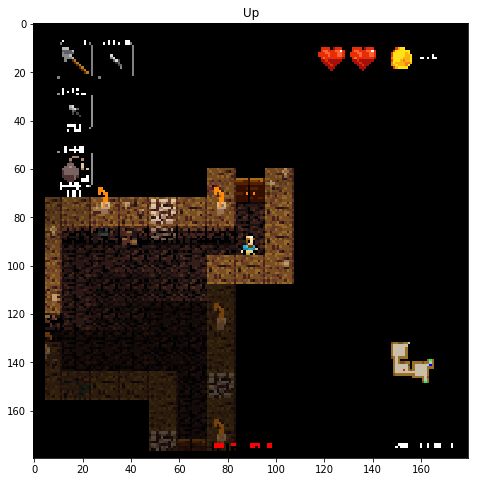

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print("Train image shape: ", images[0].shape)

# plt.imshow((images[0].numpy() * dset_std/255 + dset_mean/255).transpose(1,2,0))
plt.imshow((images[0].numpy() * channel_stds.reshape((3,1,1)) + channel_means.reshape((3,1,1))).transpose(1,2,0))

labelNames = {0:"Up",1:"Right",2:"Down",3:"Left"}
_ = plt.title(labelNames[labels[0].item()])

# Define training and validation functions

In [9]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [10]:
def check_model_accuracy(loader, model, name): 
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            if usingQuad:
                split = (x[:,:,:,:180],x[:,:,:,180:360],x[:,:,:,360:540],x[:,:,:,540:720])
                if earlyIntegration:
                    scores = model(torch.cat((split[0],split[1],split[2],split[3]), dim=1))
                else:
                    scores = model(split)
            else:
                scores = model(x)
            
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('%s set: Got %d / %d correct (%.2f)' % (name, num_correct, num_samples, 100 * acc))
    return acc

In [11]:
# Constant to control how frequently we check val loss
print_every = (num_train/128)//2 + 1 # 

def train_model(model, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    train_losses, train_accuracy, val_accuracy = [], [], []
    best_val = 0
    timestamp = time.strftime("%m_%d_T%H_%M") # time started training, best val model will be saved with this
    modelFile = None
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print('Epoch {}'.format(e))
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            if usingQuad:
                split = (x[:,:,:,:180],x[:,:,:,180:360],x[:,:,:,360:540],x[:,:,:,540:720])
                if earlyIntegration:
                    scores = model(torch.cat((split[0],split[1],split[2],split[3]), dim=1))
                else:
                    scores = model(split)
            else:
                scores = model(x)
            
            loss = F.cross_entropy(scores, y)
            train_losses.append(loss.item())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                val = check_model_accuracy(val_loader, model, 'Val')
                if val > best_val:
                    # save the best model over the course of training
                    modelFile = 'models/cloningCNN_val{}_{}.pt'.format(int(val*100),timestamp)
                    torch.save(model.state_dict(), modelFile)
                    best_val = val
                if t == 0:
                    train_accuracy.append(check_model_accuracy(train_loader, model, 'Train'))
                    val_accuracy.append(val)
                print()
        
    return (train_losses, train_accuracy, val_accuracy, modelFile)

# Load model defined in BCModel.py

In [12]:
from cloningCNN import CloningCNN
from cloningCNN import MultiSequentialCNN
from cloningCNN import ResNet

model = CloningCNN('deeper', dropout=0.5, inChannels=3)
# model = MultiSequentialCNN(netType='original', dropout=0) #this is drop probability
# model = ResNet()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
# optimizer = optim.Adam([{'params':model.resnet.fc.parameters()}
#                       ], lr=3e-5) #for resnet

# Train on the dataset!

In [13]:
train_losses, train_accuracy, val_accuracy, modelFile = train_model(model, optimizer, epochs=9)

Epoch 0
Iteration 0, loss = 1.3899
Val set: Got 367 / 1250 correct (29.36)
Train set: Got 3199 / 11251 correct (28.43)

Iteration 49, loss = 1.0068
Val set: Got 698 / 1250 correct (55.84)

Epoch 1
Iteration 0, loss = 0.9107
Val set: Got 836 / 1250 correct (66.88)
Train set: Got 7598 / 11251 correct (67.53)

Iteration 49, loss = 0.9004
Val set: Got 884 / 1250 correct (70.72)

Epoch 2
Iteration 0, loss = 0.8259
Val set: Got 896 / 1250 correct (71.68)
Train set: Got 8292 / 11251 correct (73.70)

Iteration 49, loss = 0.7879
Val set: Got 918 / 1250 correct (73.44)

Epoch 3
Iteration 0, loss = 0.6542
Val set: Got 919 / 1250 correct (73.52)
Train set: Got 8539 / 11251 correct (75.90)

Iteration 49, loss = 0.7756
Val set: Got 915 / 1250 correct (73.20)

Epoch 4
Iteration 0, loss = 0.5285
Val set: Got 940 / 1250 correct (75.20)
Train set: Got 8943 / 11251 correct (79.49)

Iteration 49, loss = 0.7872
Val set: Got 946 / 1250 correct (75.68)

Epoch 5
Iteration 0, loss = 0.4621
Val set: Got 941 / 1

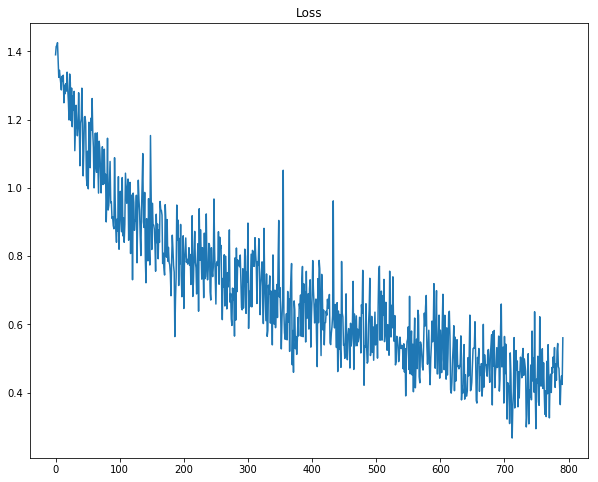

In [14]:
plt.plot(train_losses)
plt.title("Loss")
plt.show()

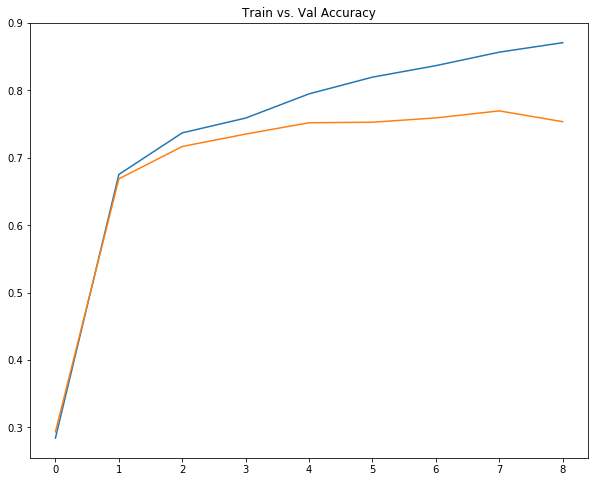

In [15]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title("Train vs. Val Accuracy")
plt.show()

In [16]:
model.load_state_dict(torch.load(modelFile))

In [17]:
check_model_accuracy(val_loader, model, 'Val')

Val set: Got 973 / 1250 correct (77.84)


0.7784